## Establish connection

In [1]:
!pip install mysql.connector

import xlrd
import mysql.connector
import pandas as pd

conexion = mysql.connector.connect(
    host="**********.cxlpff3hacbu.eu-west-3.rds.amazonaws.com",
    user="********",
    password="**********"
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=f8357422fbf31096c2e9cc02b2581d0a5cfbcea821cc00ab95bc06ea95b68994
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


## Open the cursor to the bbdd

In [2]:
nombre_base_datos = "sandbox"
nombre_tabla_ventas = "DSIIIMSA_ventas"
nombre_tabla_calendario = "DSIIIMSA_calendario"

cursor = conexion.cursor()
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {nombre_base_datos}")
cursor.execute(f"USE {nombre_base_datos}")

# Create tables and load data from excel files, generate views.

## Load sales file & initial EDA

In [3]:
df = pd.read_excel('ArticulosPanaderia.xlsx')


In [4]:
df.head(5)

,FAMILIA,Tipo,FechaVenta,HoraVenta,Articulo,Cantidad,Precio,Importe
0,BOLLERIA,VENTA,2017-01-01,8,5820,3.0,4.091,12.273
1,BOLLERIA,VENTA,2017-01-01,9,3880,12.0,2.182,26.184
2,BOLLERIA,VENTA,2017-01-01,9,3894,6.0,3.000,18.000
3,BOLLERIA,VENTA,2017-01-01,9,3960,21.0,1.773,37.233
4,BOLLERIA,VENTA,2017-01-01,9,3974,15.0,3.273,49.095


In [5]:
df.describe()

,FechaVenta,HoraVenta,Articulo,Cantidad,Precio,Importe
count,940425,940425.000000,940425.000000,940425.000000,940425.000000,940425.000000
mean,2020-06-27 18:15:55.781482240,14.296025,4083.114564,11.739958,4.708956,32.383914
min,2017-01-01 00:00:00,0.000000,174.000000,-315.000000,0.433000,-268.776000
25%,2019-05-22 00:00:00,11.000000,1084.000000,3.000000,2.163000,11.454000
50%,2020-09-29 00:00:00,14.000000,5535.000000,6.000000,3.000000,19.638000
75%,2022-01-28 00:00:00,18.000000,6272.000000,15.000000,3.818000,37.632000
max,2023-05-18 00:00:00,22.000000,9429.000000,2712.000000,163.364000,79978.200000
std,NaN,3.954288,2449.374293,17.523876,8.333156,91.573022


In [10]:
# As we have seen that there are negative values in 'Cantidad', we inspext them deeper.
df_ordered_cant = df.sort_values(by='Cantidad')
df_ordered_cant.head()

,FAMILIA,Tipo,FechaVenta,HoraVenta,Articulo,Cantidad,Precio,Importe
715154,PANADERIA,VENTA,2022-05-07,10,854,-315.0,0.721,-227.115
766346,PANADERIA,VENTA,2023-03-01,15,900,-174.0,1.050,-182.700
766351,PANADERIA,VENTA,2023-03-01,15,1084,-60.0,1.200,-72.000
728838,PANADERIA,VENTA,2022-07-26,8,900,-48.0,1.010,-48.480
374658,BOLLERIA,VENTA,2022-07-23,8,3880,-27.0,3.273,-88.371


In [12]:
cant_negative = df['Cantidad'] < 0
df[cant_negative]


,FAMILIA,Tipo,FechaVenta,HoraVenta,Articulo,Cantidad,Precio,Importe
58361,BOLLERIA,VENTA,2017-09-15,14,2854,-6.0,3.273,-19.638
95764,BOLLERIA,VENTA,2018-02-26,18,6708,-15.0,1.364,-20.460
95765,BOLLERIA,VENTA,2018-02-26,18,6709,-9.0,1.500,-13.500
177508,BOLLERIA,VENTA,2020-01-09,11,6709,-6.0,1.909,-11.454
178970,BOLLERIA,VENTA,2020-01-15,18,6008,-3.0,3.136,-9.408
...,...,...,...,...,...,...,...,...
920103,PASTELERIA,VENTA,2022-10-26,20,6492,-3.0,62.591,-187.773
922774,PASTELERIA,VENTA,2022-11-24,14,6451,-3.0,43.500,-130.500
935304,PASTELERIA,VENTA,2023-03-29,13,5619,-3.0,4.364,-13.092
935305,PASTELERIA,VENTA,2023-03-29,13,5837,-3.0,4.636,-13.908


In [17]:
# Clean the dataset getting off 61 negative rows: from initial 940425 rows to final 940364
cant_positive = df['Cantidad'] >= 0
df = df[cant_positive]
df

,FAMILIA,Tipo,FechaVenta,HoraVenta,Articulo,Cantidad,Precio,Importe
0,BOLLERIA,VENTA,2017-01-01,8,5820,3.00,4.091,12.2730
1,BOLLERIA,VENTA,2017-01-01,9,3880,12.00,2.182,26.1840
2,BOLLERIA,VENTA,2017-01-01,9,3894,6.00,3.000,18.0000
3,BOLLERIA,VENTA,2017-01-01,9,3960,21.00,1.773,37.2330
4,BOLLERIA,VENTA,2017-01-01,9,3974,15.00,3.273,49.0950
...,...,...,...,...,...,...,...,...
940420,PASTELERIA,VENTA,2023-05-18,20,5619,6.00,4.364,26.1840
940421,PASTELERIA,VENTA,2023-05-18,20,7689,6.00,4.909,29.4540
940422,PASTELERIA,VENTA,2023-05-18,20,5730,3.00,4.364,13.0920
940423,PASTELERIA,VENTA,2023-05-18,20,5936,0.57,65.318,37.2313


In [18]:
# Create Sales table in bbdd
cursor.execute(f"DROP TABLE IF EXISTS {nombre_tabla_ventas}")
cursor.execute(f"CREATE TABLE IF NOT EXISTS {nombre_tabla_ventas} ("
               "FAMILIA VARCHAR(255),"
               "Tipo VARCHAR(255),"
               "FechaVenta DATE,"
               "HoraVenta INT,"
               "Articulo VARCHAR(255),"
               "Cantidad FLOAT,"
               "Precio FLOAT,"
               "Importe FLOAT"
               ")")

In [19]:
# Load df into sales table

registros = []
for _, row in df.iterrows():
    familia = row['FAMILIA']
    tipo = row['Tipo']
    fecha_venta = row['FechaVenta'].strftime('%Y-%m-%d')
    hora_venta = row['HoraVenta']
    articulo = row['Articulo']
    cantidad = row['Cantidad']
    precio = row['Precio']
    importe = row['Importe']
    registros.append((familia, tipo, fecha_venta, hora_venta, articulo, cantidad, precio, importe))

# Create the query
consulta = f"INSERT INTO {nombre_tabla_ventas} (FAMILIA, Tipo, FechaVenta, HoraVenta, Articulo, Cantidad, Precio, Importe) " \
           "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"

# Execute the query with commits by lots
tamano_lote = 1000
for i in range(0, len(registros), tamano_lote):
    lote_registros = registros[i:i + tamano_lote]
    cursor = conexion.cursor()
    cursor.executemany(consulta, lote_registros)
    conexion.commit()

'DSIIIMSA_ventas' 🔝🙂 --> **940364 rows.**




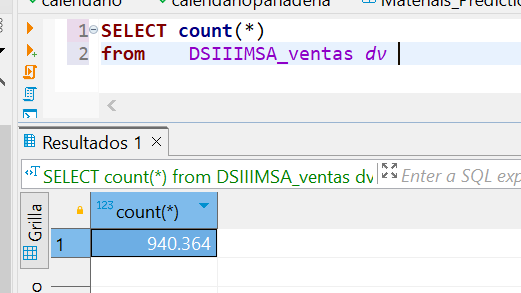

## Load holidays file & initial EDA

In [20]:
df = pd.read_excel('Calendario.xlsx')


In [21]:
df.head(5)

,Fecha,Festivo
0,2017-01-01,Año Nuevo
1,2017-01-06,Día de Reyes
2,2017-02-14,Día de San Valentín
3,2017-03-19,Día del Padre
4,2017-04-09,Domingo de Ramos


In [23]:
# calendar from 01/01/2017 to 31/12/2023
df.describe()

,Fecha
count,218
mean,2020-06-12 13:32:28.623853312
min,2017-01-01 00:00:00
25%,2018-08-16 06:00:00
50%,2020-04-07 12:00:00
75%,2022-04-16 18:00:00
max,2023-12-31 00:00:00


In [24]:
# Just in case, drop duplicates

df = df.drop_duplicates()
df.describe()


,Fecha
count,218
mean,2020-06-12 13:32:28.623853312
min,2017-01-01 00:00:00
25%,2018-08-16 06:00:00
50%,2020-04-07 12:00:00
75%,2022-04-16 18:00:00
max,2023-12-31 00:00:00


In [26]:
# Create Calendar table in bbdd
cursor.execute(f"DROP TABLE IF EXISTS {nombre_tabla_calendario}")
cursor.execute(f"CREATE TABLE IF NOT EXISTS {nombre_tabla_calendario} ("
               "Fecha DATE,"
               "Festivo VARCHAR(255)"
               ")")

In [27]:
 # Load df into calendar table

registros = []
for _, row in df.iterrows():
    fecha = row['Fecha'].strftime('%Y-%m-%d')
    festivo = row['Festivo']
    registros.append((fecha,festivo))

# Create the query
consulta = f"INSERT INTO {nombre_tabla_calendario} (Fecha, Festivo) " \
           "VALUES (%s, %s)"

# Execute the query with commits by lots
tamano_lote = 1000
for i in range(0, len(registros), tamano_lote):
    lote_registros = registros[i:i + tamano_lote]
    cursor = conexion.cursor()
    cursor.executemany(consulta, lote_registros)
    conexion.commit()

'DSIIIMSA_calendario' 🔝🙂 --> **218 rows.**




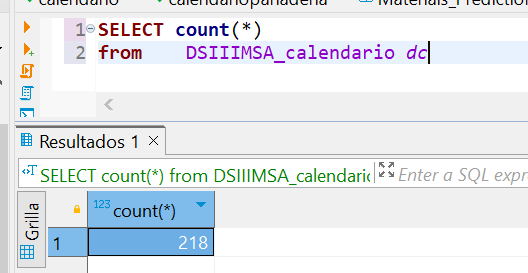

## Querys and final outputs

In [28]:
# Query using concat
# Inputs DSIIIMSA_ventas y DSIIIMSA_calendario

# Outputs sales: filter from 01/05/2021, TOP 5 articles from family and with data about holidays
# - DSIIIMSA_ventas_diarias_estudio_completo <-- the whole set, from 01/05/2021 to 31/05/2023
# - DSIIIMSA_ventas_diarias_estudio <-- for training the model, from 01/05/2021 to 30/04/2023

consulta_proceso="""


/*Ordenamos los productos por familia*/
drop table if exists DSIIIMSA_articulos_top;
create table DSIIIMSA_articulos_top as (

	select
	Articulo,
	FAMILIA,
	sum(importe) as importe_total,
	ROW_NUMBER () OVER(partition by FAMILIA order by sum(importe) desc) as orden
	from DSIIIMSA_ventas
	where FechaVenta >= '2021-05-01'
	group by 1,2

);


/*Creamos un calendario general del 1/1/2017 al 31/12/2023*/
drop table if exists DSIIIMSA_calendario_dias;
create table DSIIIMSA_calendario_dias as (

with recursive cte_calendario as (
	select date('2017-01-01') as calendar_date -- fecha de inicio
	union all
	select date_add(calendar_date, interval 1 day) as calendar_date from cte_calendario
	where date_add(calendar_date, interval 1 day) <= date('2023-12-31') -- condicion de fin, fecha final
)

select
calendar_date as fecha,
year(calendar_date) as fx_anno,
month(calendar_date) as fx_mes,
day(calendar_date) as fx_day,
date_format(calendar_date, '%Y%m') as fx_anno_mes,
date_format(calendar_Date,'%x-%v') as semana -- formato
from cte_calendario

);

/*Añadimos al calendario los festivos*/
drop table if exists DSIIIMSA_calendario_completo;
create table DSIIIMSA_calendario_completo as (
select
base.*,
festivos.festivo
from DSIIIMSA_calendario_dias base
left join
	(select
	a.*,
	row_number() over(partition by a.fecha order by a.festivo) as orden
	from DSIIIMSA_calendario a
	) festivos
on base.fecha=festivos.fecha
and festivos.orden=1
);

/*Agregamos las ventas por día (quitamos el detalle por hora)*/
/*Añadimos además el orden del producto y si está en el rango de fecha de estudio*/

drop table if exists DSIIIMSA_ventas_diarias;
create table DSIIIMSA_ventas_diarias as (
select
base.familia,
base.tipo,
base.fechaVenta,
calendario.festivo,
base.articulo,
sum(base.precio*base.cantidad)/sum(base.cantidad) as precio, /* Se calcula como el precio promedio del día, ya que hay cambios de precio a lo largo del día*/
articulos.orden as orden_articulo_familia,
case when base.fechaVenta >=date('2021-05-01') then 'S' else 'N' end as in_fecha_estudio,
sum(base.cantidad) as cantidad,
sum(base.importe) as importe

from DSIIIMSA_ventas base

inner join DSIIIMSA_calendario_completo calendario
on base.FechaVenta=calendario.fecha

inner join DSIIIMSA_articulos_top articulos
on base.familia=articulos.familia
and base.articulo=articulos.articulo


group by 1,2,3,4,5,7,8);


/*Creamos una vista final con el filtrado para el estudio*/
drop view if exists DSIIIMSA_ventas_diarias_estudio_completo;
create view DSIIIMSA_ventas_diarias_estudio_completo as
(select *
from DSIIIMSA_ventas_diarias
where tipo='VENTA'
and in_fecha_estudio='S'
and orden_articulo_familia<=5);


/*Creamos una vista extra con el filtrado para el estudio que no tenga días de mayo 23 (que habrá que predecir)*/
drop view if exists DSIIIMSA_ventas_diarias_estudio;
create view DSIIIMSA_ventas_diarias_estudio as
(select *
from DSIIIMSA_ventas_diarias
where tipo='VENTA'
and in_fecha_estudio='S'
and fechaventa < date('2023-05-01')
and orden_articulo_familia<=5);
"""

In [29]:
# Separate queries into a list
consultas_lista = consulta_proceso.split(";")

# Remove whitespace and empty elements
consultas_lista = [consulta.strip() for consulta in consultas_lista if consulta.strip()]

# Run the queries
for consulta in consultas_lista:
    cursor.execute(consulta)

# Confirm changes
conexion.commit()

'DSIIIMSA_ventas_diarias_estudio_completo' 🔝🙂 --> **10574 rows.**

---

TOP5 de MAY21 a MAY23




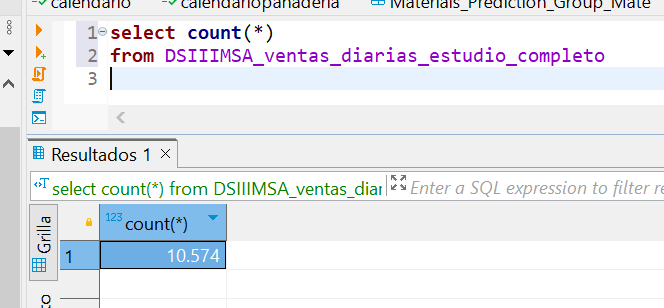

'DSIIIMSA_ventas_diarias_estudio' 🔝🙂 --> **10322 rows.**

---

TOP5 de MAY21 a ABR23




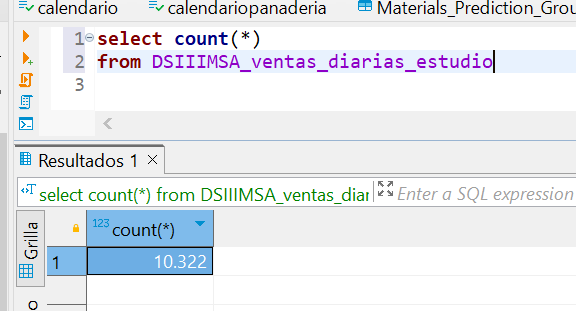